In [1]:
!pip install nltk scikit-learn numpy pandas -q

**Dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Understanding the dataset

In [3]:
df= pd.read_csv("movies.csv")

In [4]:
df.shape #(row, columns)

(4803, 24)

In [5]:
df.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [6]:
required_columns =["genres","keywords", "title", "overview"]
df= df[required_columns]
df.head(2)

,genres,keywords,title,overview
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."


In [7]:
df= df.dropna().reset_index(drop=True)

In [8]:
# this is to combine every word into one column
df['combined']= df['genres'] + ' '+ df['keywords']+ ' '+ df['overview']


In [9]:
data=df[['title', 'combined']]
data.head()

,title,combined
0,Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...


In [10]:
combined_text = " ".join(df['combined'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text)


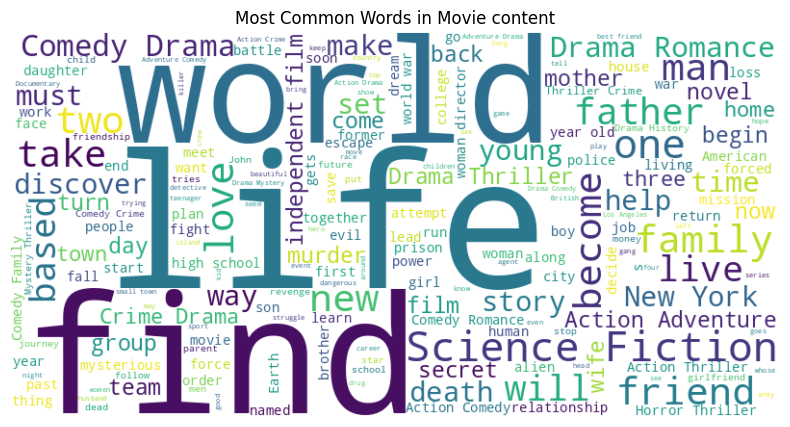

In [11]:
# WordCloud to visualize the most common words in the movie content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Movie content")
plt.show()


In [12]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def process_text(text):
  #Removes characters and numbers. ^ means not and it subs those characters with write spaces
  text = re.sub(r"[^a-zA-Z\s]", "", text)
  text= text.lower()
  # Word tokenization: splitting sentences into words.
  tokens=word_tokenize(text)
  tokens= [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [14]:
data['cleaned_text']= df['combined'].apply(process_text)
data.head(2)

<ipython-input-14-3d3055236088>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text']= df['combined'].apply(process_text)


,title,combined,cleaned_text
0,Avatar,Action Adventure Fantasy Science Fiction cultu...,action adventure fantasy science fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...,adventure fantasy action ocean drug abuse exot...


In [15]:
#Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [16]:
from difflib import get_close_matches

def recommend_movies(movie_name, cosine_sim=cosine_sim,df=data,top_n=5):
  #finding the index of the movie
  titles = df['title'].tolist()
  movie_name = movie_name.strip().lower()
  close_matches = get_close_matches(movie_name, [t.lower() for t in titles], n=1, cutoff=0.6)

  if not close_matches:
        return "❌ Movie not found. Try a different title?"
      # Get original casing title from df
  matched_title = next(t for t in titles if t.lower() == close_matches[0])
  idx = df[df['title'] == matched_title].index[0]

   # Get similarity scores
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)# sorts it in decending order
  sim_scores = sim_scores[1:top_n+1]  # Exclude the movie itself

  movie_indices =[i[0]for i in sim_scores]

  print( f"🔎 Showing results for: **{matched_title}**")

  return df[['title']].iloc[movie_indices]



In [19]:
row_index = df[df['title'] == "El Mariachi"].index
print(row_index)
movie_name = "Toy Story"

Index([4384], dtype='int64')


In [20]:

recommendations = recommend_movies(movie_name)
print(recommendations)

🔎 Showing results for: **Toy Story**
                    title
425        Over the Hedge
1048         A Bug's Life
340           Toy Story 2
3308  A Shine of Rainbows
1310         Dolphin Tale
